In [6]:
from utils import load_json
import pandas as pd
import json

In [10]:
# Modelos Simples

single_model_predict_path= './predict_data/text_predictions.json'

predict_json = load_json(single_model_predict_path)

df = pd.DataFrame(predict_json.values())

print(df.info())

df.head()

from utils import format_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9654 entries, 0 to 9653
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   question         9654 non-null   object 
 1   model            9654 non-null   object 
 2   response         9654 non-null   object 
 3   answer           9350 non-null   object 
 4   correct          9654 non-null   bool   
 5   time             9654 non-null   float64
 6   response_length  9654 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 462.1+ KB
None


,question,model,response,answer,correct,time,response_length
0,2009141,deepseek-r1,"<think>\nOkay, so I have this question about b...",D,True,23.773490,3640
1,2009145,deepseek-r1,"<think>\nOkay, so I have this probability prob...",None,False,15.596646,2793
2,2009151,deepseek-r1,"<think>\nPrimeiro, vamos definir a despesa tot...",C,False,25.421569,2982
3,2009152,deepseek-r1,"<think>\nPrimeiro, preciso entender a relação ...",E,True,7.647103,1097
4,2009154,deepseek-r1,"<think>\nAlright, let me try to figure this pr...",None,False,55.143997,9535


In [19]:
import pandas as pd
import json

def test_table(predict_path: str, total_questions: int | None = None, models: list[str] | None = None) -> pd.DataFrame:
    with open(predict_path) as f:
        predict_data = json.load(f)
    
    models_dict = {model: [] for model in models} if models is not None else {}
    
    for question in predict_data.values():
        if question["model"] in models_dict:
            models_dict[question["model"]].append(question)
        elif models is not None and question["model"] not in models:
            continue
        else:
            models_dict[question["model"]] = [question]
    
    if total_questions is None:
        total_questions = max(len(qs) for qs in models_dict.values()) if models_dict else len(predict_data)
    
    table_data = []
    total_completed = total_corrects = total_errors = total_nulls = total_exec_time = total_estimed_time_left = 0
    total_min_time = float("inf")
    total_max_time = 0

    for model_name, model_questions in models_dict.items():
        completed = len(model_questions)
        corrects = sum(q["correct"] for q in model_questions)
        null_responses = sum(1 for q in model_questions if q["answer"] is None)
        errors = completed - corrects - null_responses
        accuracy = corrects / max(1, completed)
        total_time = sum(q["time"] for q in model_questions)
        avg_time = total_time / max(1, completed)
        max_time = max((q["time"] for q in model_questions), default=0)
        min_time = min((q["time"] for q in model_questions), default=float("inf"))
        estimated_time_left = (avg_time * (total_questions - completed)) if completed > 0 else 0

        total_completed += completed
        total_corrects += corrects
        total_errors += errors
        total_nulls += null_responses
        total_exec_time += estimated_time_left
        total_min_time = min(total_min_time, min_time)
        total_max_time = max(total_max_time, max_time)

        table_data.append([
            model_name, completed, corrects, null_responses, errors, accuracy,
            total_time, estimated_time_left, avg_time, max_time, min_time
        ])
    
    table_data.append([
        "TOTAL", total_completed, total_corrects, total_nulls, total_errors,
        total_corrects / max(1, total_completed), total_exec_time,
        (total_exec_time / max(1, total_completed)) * (total_questions - total_completed) if total_completed > 0 else 0,
        total_exec_time / max(1, total_completed), total_max_time, total_min_time
    ])

    return pd.DataFrame(table_data, columns=["Model", "Finish", "OK", "Null", "Err", "Acc", "Ttot", "Tle", "Tavg", "Tmax", "Tmin"])

def format_test_table(df: pd.DataFrame) -> pd.DataFrame:
    """Converte valores numéricos de tempo para string formatada na tabela."""
    df_copy = df.copy()
    for col in ["Ttot", "Tle", "Tavg", "Tmax", "Tmin"]:
        df_copy[col] = df_copy[col].apply(format_time)
    df_copy["Finish"] = df_copy["Finish"].astype(str) + " (" + (df_copy["Finish"].astype(float) / df_copy["Finish"].max() * 100).round(0).astype(int).astype(str) + "%)"
    return df_copy


In [20]:
single_model_table = test_table(single_model_predict_path)
single_model_table

,Model,Finish,OK,Null,Err,Acc,Ttot,Tle,Tavg,Tmax,Tmin
0,deepseek-r1,1609,883,127,599,0.548788,32784.816463,0.0,20.375896,469.823419,2.529047
1,llama3.2,1609,426,28,1155,0.264761,533.942759,0.0,0.331848,41.733469,0.086080
2,llava,1609,730,77,802,0.453698,922.123624,0.0,0.573104,12.115683,0.151764
3,mistral,1609,931,30,648,0.578620,1478.200308,0.0,0.918707,20.847775,0.169479
4,phi4,1609,1337,12,260,0.830951,10446.196960,0.0,6.492354,106.759996,0.320840
5,gemma2,1609,1208,30,371,0.750777,999.917122,0.0,0.621453,11.382335,0.271672
6,TOTAL,9654,5515,304,3835,0.571266,0.000000,-0.0,0.000000,469.823419,0.086080


In [22]:
single_model_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Model   7 non-null      object 
 1   Finish  7 non-null      int64  
 2   OK      7 non-null      int64  
 3   Null    7 non-null      int64  
 4   Err     7 non-null      int64  
 5   Acc     7 non-null      float64
 6   Ttot    7 non-null      float64
 7   Tle     7 non-null      float64
 8   Tavg    7 non-null      float64
 9   Tmax    7 non-null      float64
 10  Tmin    7 non-null      float64
dtypes: float64(6), int64(4), object(1)
memory usage: 748.0+ bytes


In [27]:
import matplotlib.pyplot as plt

def plot_model_performance(df: pd.DataFrame):
    """Gera um gráfico de barras empilhadas mostrando a distribuição de acertos, nulos e erros por modelo."""
    df_sorted = df[df["Model"] != "TOTAL"].sort_values(by="OK", ascending=False)
    models = df_sorted["Model"]
    corrects = df_sorted["OK"]
    nulls = df_sorted["Null"]
    errors = df_sorted["Err"]
    total_questions = df_sorted["Finish"]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(models, corrects, color='#99FF99', label='Acertos')
    bars2 = ax.bar(models, nulls, bottom=corrects, color='#C3C3C3', label='Nulos')
    bars3 = ax.bar(models, errors, bottom=corrects + nulls, color='#FF6666', label='Erros')
    
    for bar, total, correct, null, error in zip(bars1, total_questions, corrects, nulls, errors):
        ax.text(bar.get_x() + bar.get_width()/2, correct/2, f"{(correct/total*100):.1f}%", ha='center', va='center')
        ax.text(bar.get_x() + bar.get_width()/2, correct + null/2, f"{(null/total*100):.1f}%", ha='center', va='center')
        ax.text(bar.get_x() + bar.get_width()/2, correct + null + error/2, f"{(error/total*100):.1f}%", ha='center', va='center')
    
    ax.set_ylabel("Número de Questões")
    ax.set_xlabel("Modelos")
    ax.set_title("Desempenho dos Modelos")
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()


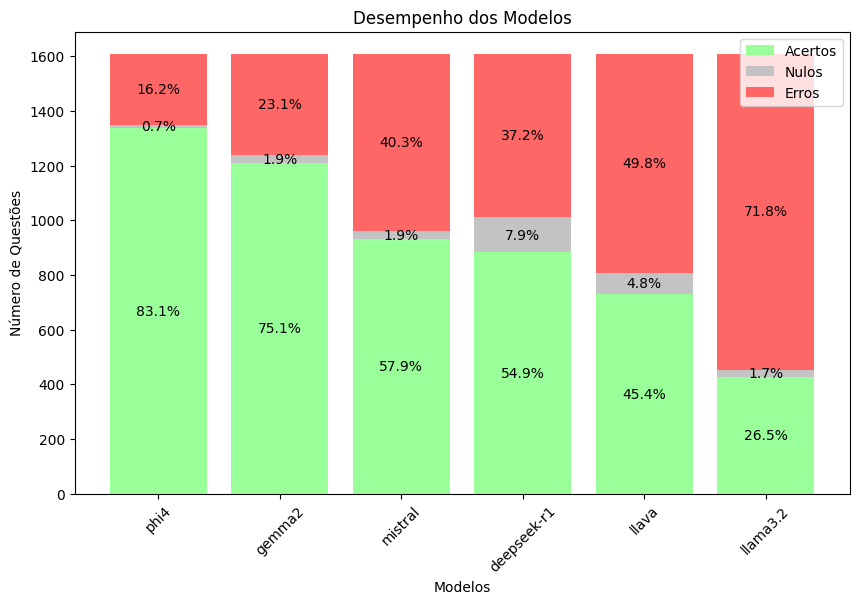

In [28]:
plot_model_performance(single_model_table)

In [31]:
def plot_time_metrics(df: pd.DataFrame):
    """Gera dois gráficos: um para tempo médio, mínimo e máximo por modelo, e outro para tempo total."""
    df_sorted = df[df["Model"] != "TOTAL"]
    models = df_sorted["Model"]
    avg_time = df_sorted["Tavg"]
    min_time = df_sorted["Tmin"]
    max_time = df_sorted["Tmax"]
    total_time = df_sorted["Ttot"] / 60  # Convertendo para minutos
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Primeiro gráfico - tempo médio, mínimo e máximo
    width = 0.2
    x = range(len(models))
    
    axes[0].bar(x, avg_time, width, label='Tempo Médio', color='#ffcc99')
    axes[0].bar([i + width for i in x], min_time, width, label='Tempo Mínimo', color='#99ccff')
    axes[0].bar([i + 2 * width for i in x], max_time, width, label='Tempo Máximo', color='#c2f0c2')
    
    for i, (avg, min_, max_) in enumerate(zip(avg_time, min_time, max_time)):
        axes[0].text(i, avg + 1, f"{avg:.2f}s", ha='center')
        axes[0].text(i + width, min_ + 1, f"{min_:.2f}s", ha='center')
        axes[0].text(i + 2 * width, max_ + 1, f"{max_:.2f}s", ha='center')
    
    axes[0].set_xticks([i + width for i in x])
    axes[0].set_xticklabels(models, rotation=45)
    axes[0].set_ylabel("Tempo (segundos)")
    axes[0].set_title("Métricas de Tempo por Modelo")
    axes[0].legend()
    
    # Segundo gráfico - tempo total por modelo
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2f0c2','#ffb3e6']
    bars = axes[1].bar(models, total_time, color=colors)
    
    for bar, time in zip(bars, total_time):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{time:.2f}m", ha='center')
    
    axes[1].set_ylabel("Tempo Total (minutos)")
    axes[1].set_title("Tempo Total por Modelo")
    
    plt.tight_layout()
    plt.show()


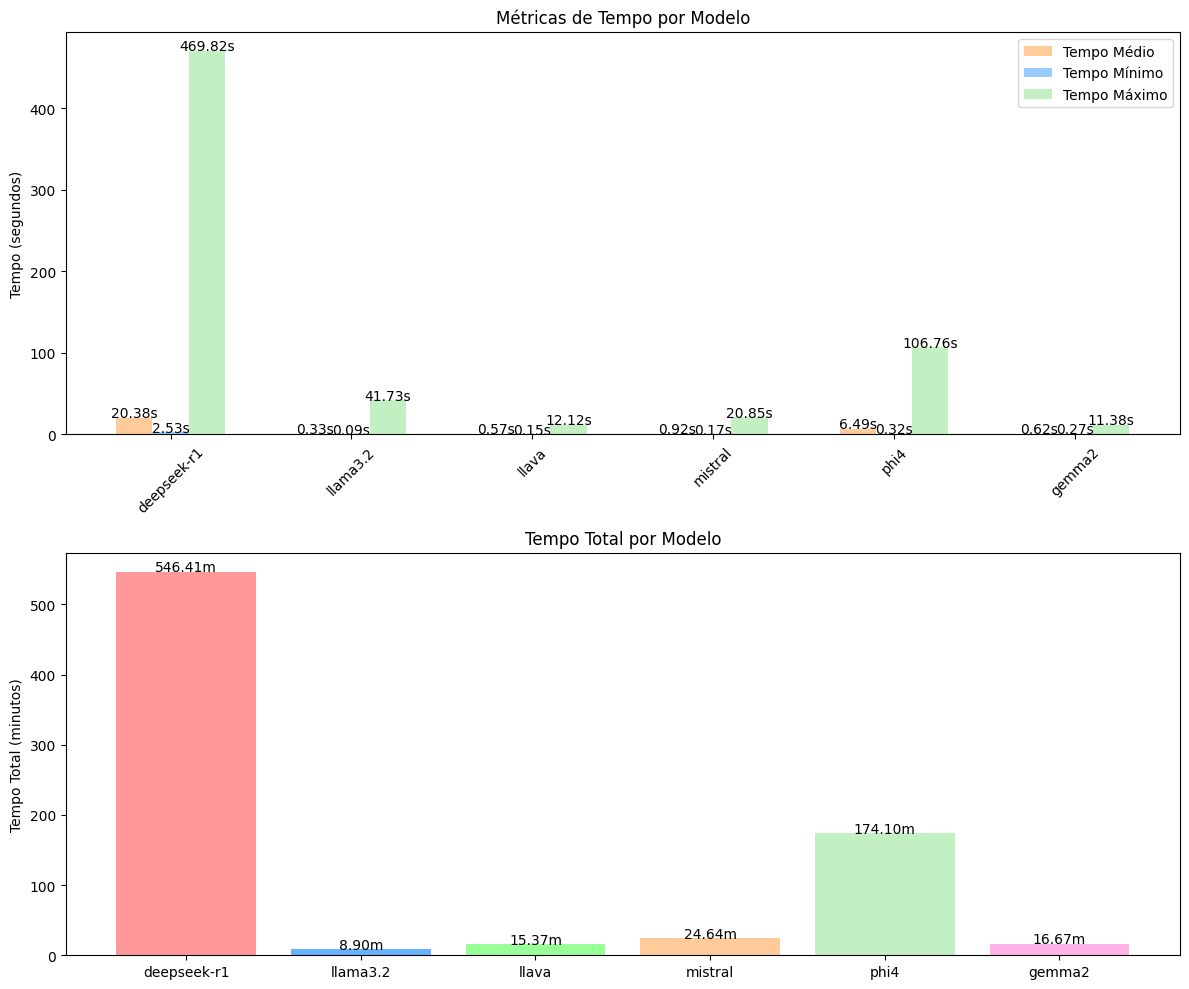

In [32]:
plot_time_metrics(single_model_table)

In [35]:
import numpy as np

def plot_accuracy_vs_time(df: pd.DataFrame):
    """Gera um gráfico de dispersão mostrando a correlação entre tempo médio e acurácia por modelo."""
    df_sorted = df[df["Model"] != "TOTAL"]
    models = df_sorted["Model"]
    avg_time = df_sorted["Tavg"]
    accuracy = df_sorted["Acc"]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.Paired(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        ax.scatter(avg_time.iloc[i], accuracy.iloc[i], color=colors[i], label=model)
        ax.text(avg_time.iloc[i], accuracy.iloc[i], model, fontsize=10, ha='right', color=colors[i])
    
    ax.set_xlabel("Tempo Médio (s)")
    ax.set_ylabel("Acurácia")
    ax.set_title("Correlação entre Tempo Médio e Acurácia por Modelo")
    
    plt.legend()
    plt.show()

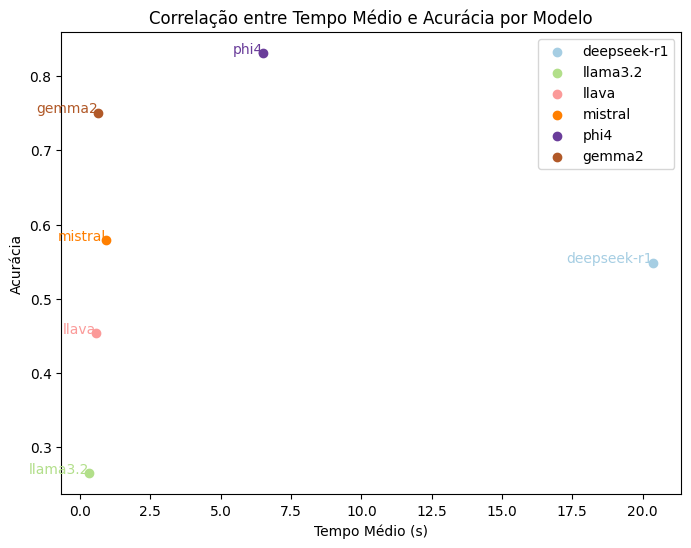

In [36]:
plot_accuracy_vs_time(single_model_table)

In [39]:
questoes = load_json('./questoes/questoes.json')
predict_json = load_json(single_model_predict_path)

questoes_dict ={
    str(q['id']) : q for q in questoes
}

for question in predict_json.values():
    question_detail = questoes_dict.get(question['question'], {})
    question['discipline'] = question_detail.get('discipline')

df = pd.DataFrame(predict_json.values())

df.head()


,question,model,response,answer,correct,time,response_length,discipline
0,2009141,deepseek-r1,"<think>\nOkay, so I have this question about b...",D,True,23.773490,3640,matematica
1,2009145,deepseek-r1,"<think>\nOkay, so I have this probability prob...",None,False,15.596646,2793,matematica
2,2009151,deepseek-r1,"<think>\nPrimeiro, vamos definir a despesa tot...",C,False,25.421569,2982,matematica
3,2009152,deepseek-r1,"<think>\nPrimeiro, preciso entender a relação ...",E,True,7.647103,1097,matematica
4,2009154,deepseek-r1,"<think>\nAlright, let me try to figure this pr...",None,False,55.143997,9535,matematica


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9654 entries, 0 to 9653
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   question         9654 non-null   object 
 1   model            9654 non-null   object 
 2   response         9654 non-null   object 
 3   answer           9350 non-null   object 
 4   correct          9654 non-null   bool   
 5   time             9654 non-null   float64
 6   response_length  9654 non-null   int64  
 7   discipline       9648 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 537.5+ KB


In [64]:
def plot_discipline_performance(df: pd.DataFrame, group_model: bool = False, normalize: bool = False):
    """Gera múltiplos gráficos de barras empilhadas mostrando a distribuição de acertos, nulos e erros por disciplina e modelo.
    Se group_model for True, agrupa os dados por modelo em vez de disciplina.
    Se normalize for True, normaliza os valores pelo total de questões em cada grupo.
    Limita a exibição a 4 modelos por gráfico para melhor visualização e adiciona separação entre grupos.
    """
    df_filtered = df.dropna(subset=["discipline"])
    
    group_by = "model" if group_model else "discipline"
    grouped = df_filtered.groupby([group_by, "model" if not group_model else "discipline"]).agg(
        OK=("correct", "sum"),
        Null=("answer", lambda x: x.isna().sum()),
        Total=("question", "count")
    ).reset_index()
    grouped["Err"] = grouped["Total"] - grouped["OK"] - grouped["Null"]
    grouped["Acc"] = grouped["OK"] / grouped["Total"]
    
    # Ordena os grupos pela acurácia
    sorted_groups = grouped.groupby(group_by)["Acc"].mean().sort_values(ascending=False).index
    grouped[group_by] = pd.Categorical(grouped[group_by], categories=sorted_groups, ordered=True)
    grouped = grouped.sort_values([group_by, "Acc"], ascending=[True, False])
    
    if normalize:
        grouped[["OK", "Null", "Err"]] = grouped[["OK", "Null", "Err"]].div(grouped["Total"], axis=0) * 100
    
    unique_groups = grouped[group_by].unique()
    group_chunks = [unique_groups[i:i+4] for i in range(0, len(unique_groups), 4)]
    
    for group_subset in group_chunks:
        fig, ax = plt.subplots(figsize=(max(12, len(group_subset) * 2), 8))
        width = 0.3
        colors = ['#99FF99', '#C3C3C3', '#FF6666']
        labels = ['Acertos', 'Nulos', 'Erros']
        
        tick_positions = []
        tick_labels = []
        x_index = 0
        spacing = 2
        
        for category in group_subset:
            category_data = grouped[grouped[group_by] == category]
            
            if category_data.empty:
                continue
            
            for i, (_, row) in enumerate(category_data.iterrows()):
                correct, null, error = row["OK"], row["Null"], row["Err"]
                total = row["Total"] if not normalize else 100
                
                tick_positions.append(x_index)
                tick_labels.append(f"{row['model'] if not group_model else row['discipline']}\n{category}")
                
                bottom = 0
                ax.bar(x_index, correct, width, color=colors[0], bottom=bottom, label=labels[0] if x_index == 0 else "")
                ax.text(x_index, bottom + correct / 2, f"{correct:.1f}%" if normalize else f"{int(correct)}", ha='center', va='center')
                bottom += correct
                
                ax.bar(x_index, null, width, color=colors[1], bottom=bottom, label=labels[1] if x_index == 0 else "")
                ax.text(x_index, bottom + null / 2, f"{null:.1f}%" if normalize else f"{int(null)}", ha='center', va='center')
                bottom += null
                
                ax.bar(x_index, error, width, color=colors[2], bottom=bottom, label=labels[2] if x_index == 0 else "")
                ax.text(x_index, bottom + error / 2, f"{error:.1f}%" if normalize else f"{int(error)}", ha='center', va='center')
                
                x_index += 1
            
            x_index += spacing  # Adiciona espaço entre grupos
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=90)
        ax.set_ylabel("Proporção (%)" if normalize else "Número Total de Questões")
        ax.set_xlabel("Modelos e Disciplinas" if not group_model else "Disciplinas e Modelos")
        ax.set_title("Desempenho por Disciplina e Modelo" if not group_model else "Desempenho por Modelo e Disciplina")
        ax.legend()
        plt.show()

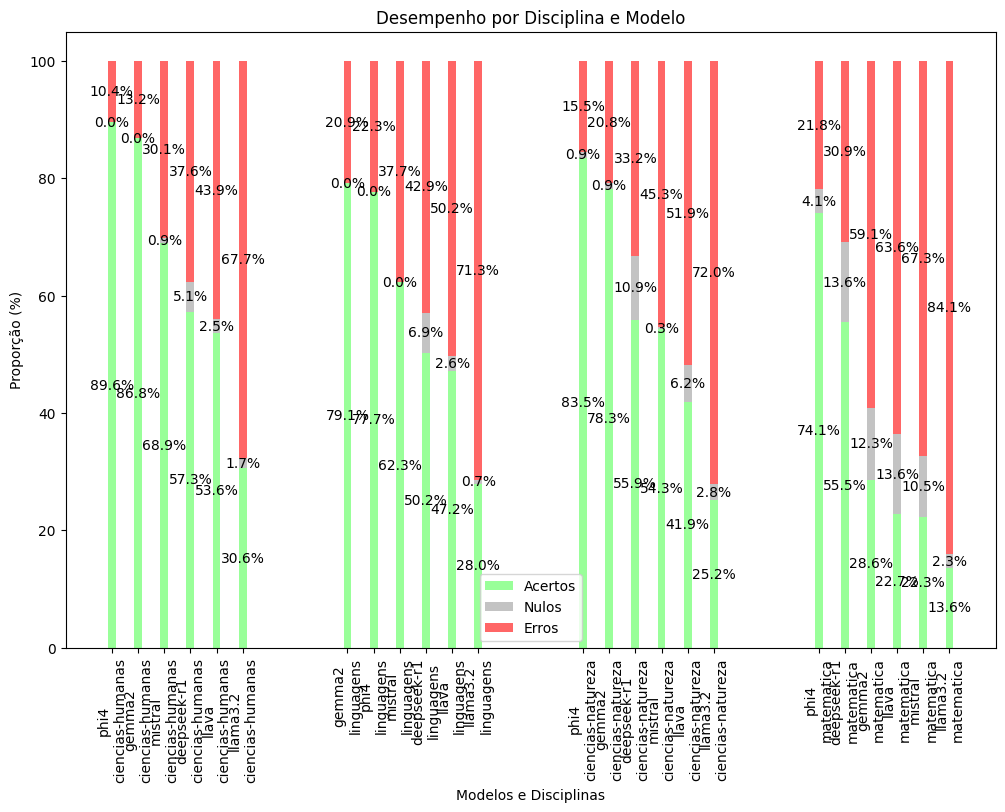

C:\Users\ruben\AppData\Local\Temp\ipykernel_52012\896647786.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_grouped = grouped.groupby(group_by).sum()


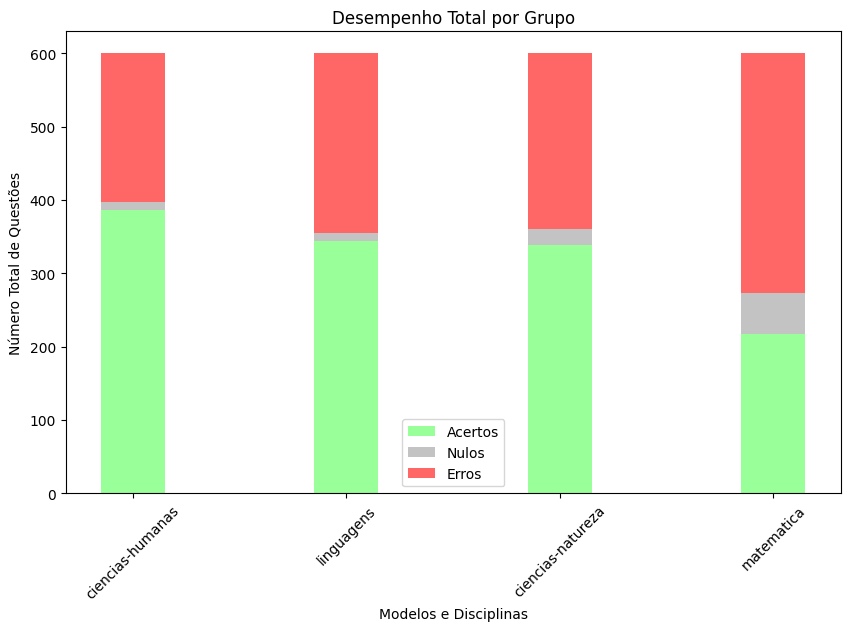

In [69]:
plot_discipline_performance(df, False, True)

In [67]:
def plot_discipline_performance(df: pd.DataFrame, group_model: bool = False, normalize: bool = False):
    """Gera múltiplos gráficos de barras empilhadas mostrando a distribuição de acertos, nulos e erros por disciplina e modelo.
    Se group_model for True, agrupa os dados por modelo em vez de disciplina.
    Se normalize for True, normaliza os valores pelo total de questões em cada grupo.
    Limita a exibição a 4 modelos por gráfico para melhor visualização e adiciona separação entre grupos.
    """
    df_filtered = df.dropna(subset=["discipline"])
    
    group_by = "model" if group_model else "discipline"
    grouped = df_filtered.groupby([group_by, "model" if not group_model else "discipline"]).agg(
        OK=("correct", "sum"),
        Null=("answer", lambda x: x.isna().sum()),
        Total=("question", "count")
    ).reset_index()
    grouped["Err"] = grouped["Total"] - grouped["OK"] - grouped["Null"]
    grouped["Acc"] = grouped["OK"] / grouped["Total"]
    
    # Ordena os grupos pela acurácia
    sorted_groups = grouped.groupby(group_by)["Acc"].mean().sort_values(ascending=False).index
    grouped[group_by] = pd.Categorical(grouped[group_by], categories=sorted_groups, ordered=True)
    grouped = grouped.sort_values([group_by, "Acc"], ascending=[True, False])
    
    if normalize:
        grouped[["OK", "Null", "Err"]] = grouped[["OK", "Null", "Err"]].div(grouped["Total"], axis=0) * 100
    
    unique_groups = grouped[group_by].unique()
    group_chunks = [unique_groups[i:i+4] for i in range(0, len(unique_groups), 4)]
    
    for group_subset in group_chunks:
        fig, ax = plt.subplots(figsize=(max(12, len(group_subset) * 2), 8))
        width = 0.3
        colors = ['#99FF99', '#C3C3C3', '#FF6666']
        labels = ['Acertos', 'Nulos', 'Erros']
        
        tick_positions = []
        tick_labels = []
        x_index = 0
        spacing = 3  # Espaço maior entre os grupos
        
        for category in group_subset:
            category_data = grouped[grouped[group_by] == category]
            
            if category_data.empty:
                continue
            
            for i, (_, row) in enumerate(category_data.iterrows()):
                correct, null, error = row["OK"], row["Null"], row["Err"]
                total = row["Total"] if not normalize else 100
                
                tick_positions.append(x_index)
                tick_labels.append(f"{row['model'] if not group_model else row['discipline']}\n{category}")
                
                bottom = 0
                ax.bar(x_index, correct, width, color=colors[0], bottom=bottom, label=labels[0] if x_index == 0 else "")
                ax.text(x_index, bottom + correct / 2, f"{correct:.1f}%" if normalize else f"{int(correct)}", ha='center', va='center')
                bottom += correct
                
                ax.bar(x_index, null, width, color=colors[1], bottom=bottom, label=labels[1] if x_index == 0 else "")
                ax.text(x_index, bottom + null / 2, f"{null:.1f}%" if normalize else f"{int(null)}", ha='center', va='center')
                bottom += null
                
                ax.bar(x_index, error, width, color=colors[2], bottom=bottom, label=labels[2] if x_index == 0 else "")
                ax.text(x_index, bottom + error / 2, f"{error:.1f}%" if normalize else f"{int(error)}", ha='center', va='center')
                
                x_index += 1
            
            x_index += spacing  # Adiciona espaço entre grupos
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=90)
        ax.set_ylabel("Proporção (%)" if normalize else "Número Total de Questões")
        ax.set_xlabel("Modelos e Disciplinas" if not group_model else "Disciplinas e Modelos")
        ax.set_title("Desempenho por Disciplina e Modelo" if not group_model else "Desempenho por Modelo e Disciplina")
        ax.legend()
        plt.show()
    
    # Plot agregado
    total_grouped = grouped.groupby(group_by).sum()
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.3
    x = np.arange(len(total_grouped))
    
    ax.bar(x, total_grouped["OK"], width, color=colors[0], label='Acertos')
    ax.bar(x, total_grouped["Null"], width, bottom=total_grouped["OK"], color=colors[1], label='Nulos')
    ax.bar(x, total_grouped["Err"], width, bottom=total_grouped["OK"] + total_grouped["Null"], color=colors[2], label='Erros')
    
    ax.set_xticks(x)
    ax.set_xticklabels(total_grouped.index, rotation=45)
    ax.set_ylabel("Número Total de Questões")
    ax.set_xlabel("Modelos e Disciplinas" if not group_model else "Disciplinas e Modelos")
    ax.set_title("Desempenho Total por Grupo")
    ax.legend()
    plt.show()


In [86]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

def format_time(seconds: float) -> str:
    """Format time in seconds to a human-readable string."""
    if seconds == float("inf"):
        return "-"
    minutes, seconds = divmod(seconds, 60)
    return f"{int(minutes)}m {seconds:.2f}s"

def plot_time_performance(df: pd.DataFrame, group_model: bool = False):
    """Gera múltiplos gráficos de barras mostrando o tempo médio por disciplina e modelo.
    Se group_model for True, agrupa os dados por modelo e disciplina.
    O eixo Y representa o tempo médio em segundos.
    Limita a exibição a 2 disciplinas por gráfico se agrupado por disciplina e 3 disciplinas por gráfico se agrupado por modelo.
    Mantém agrupamentos juntos e adiciona legenda de cores.
    """
    df_filtered = df.dropna(subset=["discipline"]).copy()
    df_filtered["time"] = pd.to_numeric(df_filtered["time"], errors="coerce")  # Garante que os tempos sejam numéricos
    
    group_by = "model" if group_model else "discipline"
    grouped = df_filtered.groupby([group_by, "discipline" if group_model else "model"]).agg(
        Avg_Time=("time", "mean"),
        Count=("question", "count")
    ).reset_index()
    
    # Ordena os grupos pelo tempo médio (menor tempo primeiro)
    sorted_groups = grouped.groupby(group_by)["Avg_Time"].mean().sort_values(ascending=True).index
    grouped[group_by] = pd.Categorical(grouped[group_by], categories=sorted_groups, ordered=True)
    grouped = grouped.sort_values([group_by, "Avg_Time"], ascending=[True, True])
    
    max_groups = 2 if not group_model else 3
    unique_groups = grouped[group_by].unique()
    group_chunks = [unique_groups[i:i+max_groups] for i in range(0, len(unique_groups), max_groups)]
    
    lista_cores = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
    categories = grouped["discipline"].unique() if group_model else grouped["model"].unique()
    color_map = {category: lista_cores[i % len(lista_cores)] for i, category in enumerate(categories)}
    
    for group_subset in group_chunks:
        fig, ax = plt.subplots(figsize=(max(12, len(group_subset) * 2), 6))
        width = 0.4
        
        subset_data = grouped[grouped[group_by].isin(group_subset)]
        x_positions = []
        tick_labels = []
        x_index = 0
        spacing = 1.5  # Espaçamento entre os grupos
        
        for category in group_subset:
            category_data = subset_data[subset_data[group_by] == category]
            
            if category_data.empty:
                continue
            
            for _, row in category_data.iterrows():
                color = color_map[row["discipline"]] if group_model else color_map[row["model"]]
                bar = ax.bar(x_index, row["Avg_Time"], width, color=color, label=row["discipline"] if group_model else row["model"])
                ax.text(x_index, row["Avg_Time"] * 1.03, f"{row['Avg_Time']:.2f}s", ha='center', fontsize=10)
                x_positions.append(x_index)
                tick_labels.append(category)
                x_index += 1
            x_index += spacing  # Adiciona espaço entre os grupos
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(tick_labels, rotation=45)
        ax.set_ylabel("Tempo Médio (segundos)")
        ax.set_xlabel("Modelos" if group_model else "Disciplinas")
        ax.set_title("Tempo Médio por Disciplina e Modelo" if not group_model else "Tempo Médio por Modelo e Disciplina")
        ax.legend(title="Disciplinas" if group_model else "Modelos")
        plt.show()
    
    # Gráfico agregado com todos os grupos
    total_grouped = grouped.groupby(group_by).mean(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(total_grouped)) * 1.5  # Espaçamento entre os grupos
    bars = ax.bar(x, total_grouped["Avg_Time"], width, color=[color_map[cat] for cat in total_grouped.index])
    
    for bar, time in zip(bars, total_grouped["Avg_Time"]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.03, f"{time:.2f}s", ha='center', fontsize=10)
    
    ax.set_xticks(x)
    ax.set_xticklabels(total_grouped.index, rotation=45)
    ax.set_ylabel("Tempo Médio (segundos)")
    ax.set_xlabel("Modelos" if group_model else "Disciplinas")
    ax.set_title("Tempo Médio por Grupo")
    ax.legend([plt.Rectangle((0,0),1,1, color=color_map[cat]) for cat in categories], categories, title="Disciplinas" if group_model else "Modelos")
    plt.show()


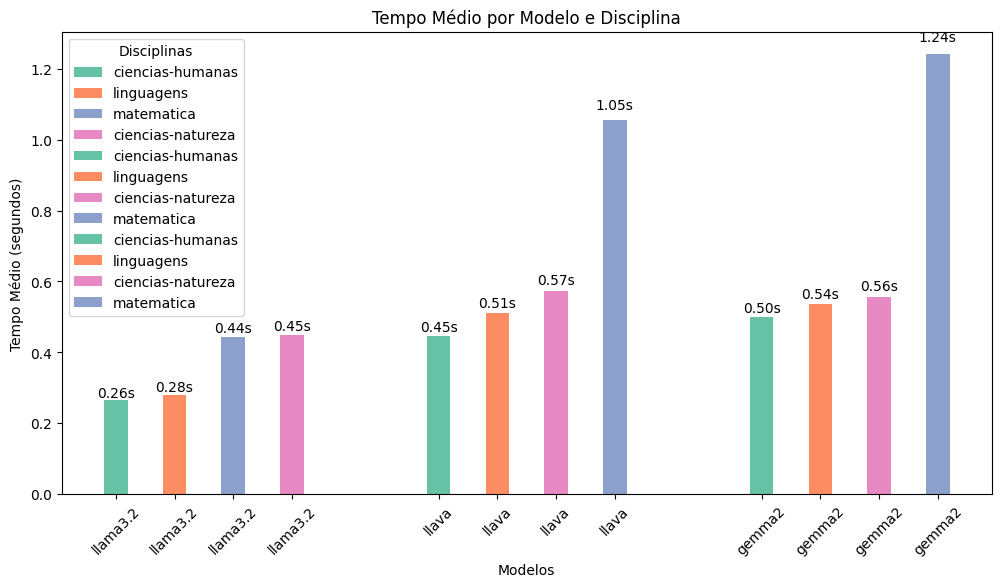

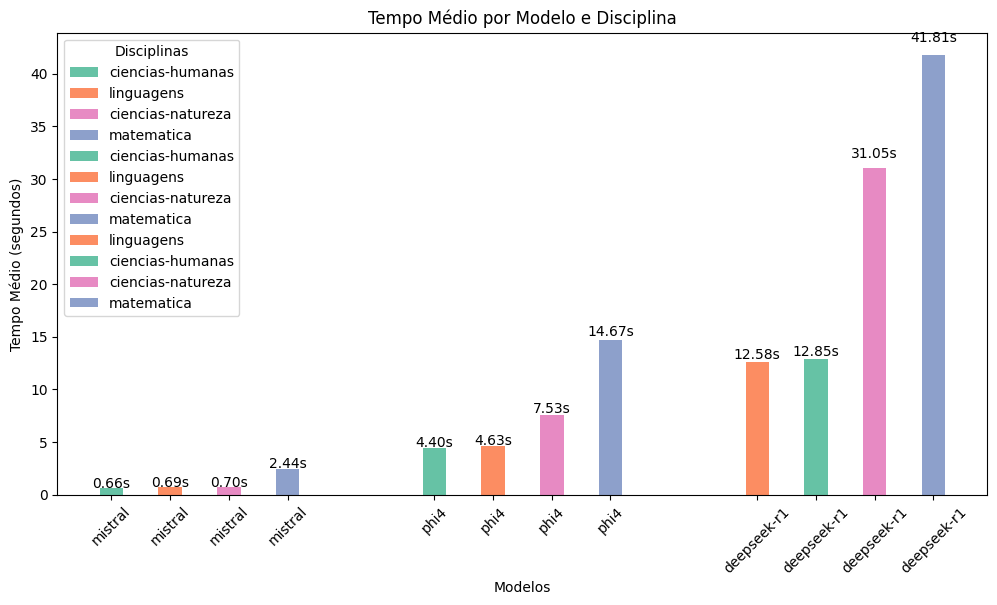

C:\Users\ruben\AppData\Local\Temp\ipykernel_52012\2316715442.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_grouped = grouped.groupby(group_by).mean(numeric_only=True)


KeyError: 'llama3.2'

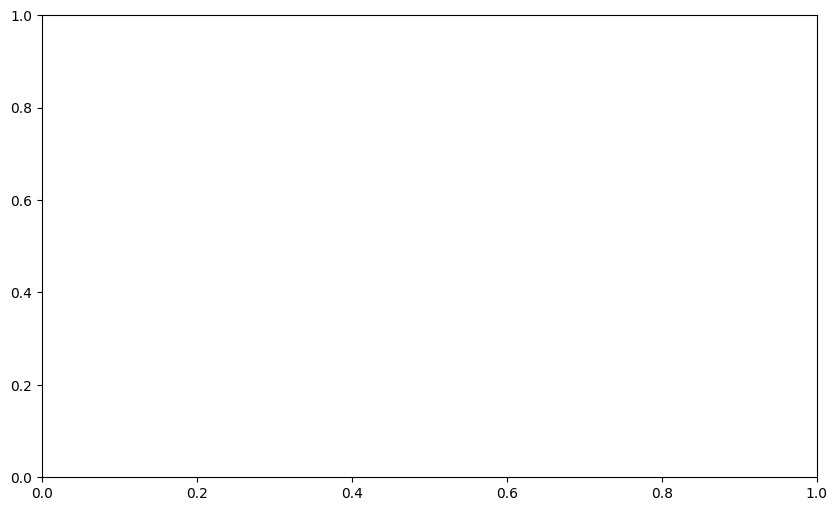

In [87]:
plot_time_performance(df, True)

In [91]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

def format_time(seconds: float) -> str:
    """Format time in seconds to a human-readable string."""
    if seconds == float("inf"):
        return "-"
    minutes, seconds = divmod(seconds, 60)
    return f"{int(minutes)}m {seconds:.2f}s"

def plot_time_performance(df: pd.DataFrame, group_model: bool = False):
    """Gera múltiplos gráficos de barras mostrando o tempo médio por disciplina e modelo.
    Se group_model for True, agrupa os dados por modelo e disciplina.
    O eixo Y representa o tempo médio em segundos.
    Limita a exibição a 2 disciplinas por gráfico se agrupado por disciplina e 3 disciplinas por gráfico se agrupado por modelo.
    Mantém agrupamentos juntos e adiciona legenda de cores.
    """
    df_filtered = df.dropna(subset=["discipline"]).copy()
    df_filtered["time"] = pd.to_numeric(df_filtered["time"], errors="coerce")  # Garante que os tempos sejam numéricos
    
    group_by = "model" if group_model else "discipline"
    grouped = df_filtered.groupby([group_by, "discipline" if group_model else "model"]).agg(
        Avg_Time=("time", "mean"),
        Count=("question", "count")
    ).reset_index()
    
    # Ordena os grupos pelo maior tempo médio
    sorted_groups = grouped.groupby(group_by)["Avg_Time"].mean().sort_values(ascending=False).index
    grouped[group_by] = pd.Categorical(grouped[group_by], categories=sorted_groups, ordered=True)
    grouped = grouped.sort_values([group_by, "Avg_Time"], ascending=[False, False])
    
    max_groups = 2 if not group_model else 3
    unique_groups = grouped[group_by].unique()
    group_chunks = [unique_groups[i:i+max_groups] for i in range(0, len(unique_groups), max_groups)]
    
    lista_cores = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
    categories = sorted(grouped["discipline"].unique()) if group_model else sorted(grouped["model"].unique())
    color_map = {category: lista_cores[i % len(lista_cores)] for i, category in enumerate(categories)}
    
    for group_subset in group_chunks:
        fig, ax = plt.subplots(figsize=(max(12, len(group_subset) * 2), 6))
        width = 0.4
        
        subset_data = grouped[grouped[group_by].isin(group_subset)]
        x_positions = []
        tick_labels = []
        x_index = 0
        spacing = 2  # Aumenta a separação entre grupos distintos
        
        for category in group_subset:
            category_data = subset_data[subset_data[group_by] == category]
            
            if category_data.empty:
                continue
            
            for _, row in category_data.iterrows():
                color = color_map[row["discipline"]] if group_model else color_map[row["model"]]
                ax.bar(x_index, row["Avg_Time"], width, color=color)
                ax.text(x_index, row["Avg_Time"] * 1.03, f"{row['Avg_Time']:.2f}s", ha='center', fontsize=10)
                x_positions.append(x_index)
                tick_labels.append(category)
                x_index += 1
            x_index += spacing  # Adiciona espaço entre os grupos
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(tick_labels, rotation=45)
        ax.set_ylabel("Tempo Médio (segundos)")
        ax.set_xlabel("Modelos" if group_model else "Disciplinas")
        ax.set_title("Tempo Médio por Disciplina e Modelo" if not group_model else "Tempo Médio por Modelo e Disciplina")
        
        # Criar a legenda corretamente sem duplicação
        unique_labels = sorted(set(color_map.keys()))
        handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in unique_labels]
        ax.legend(handles, unique_labels, title="Disciplinas" if group_model else "Modelos")
        
        plt.show()


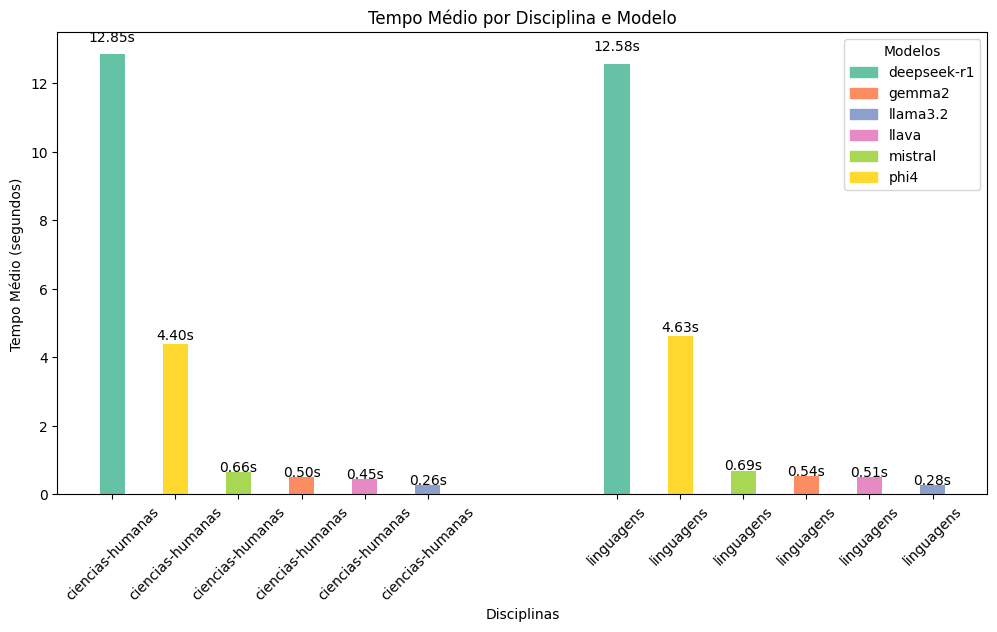

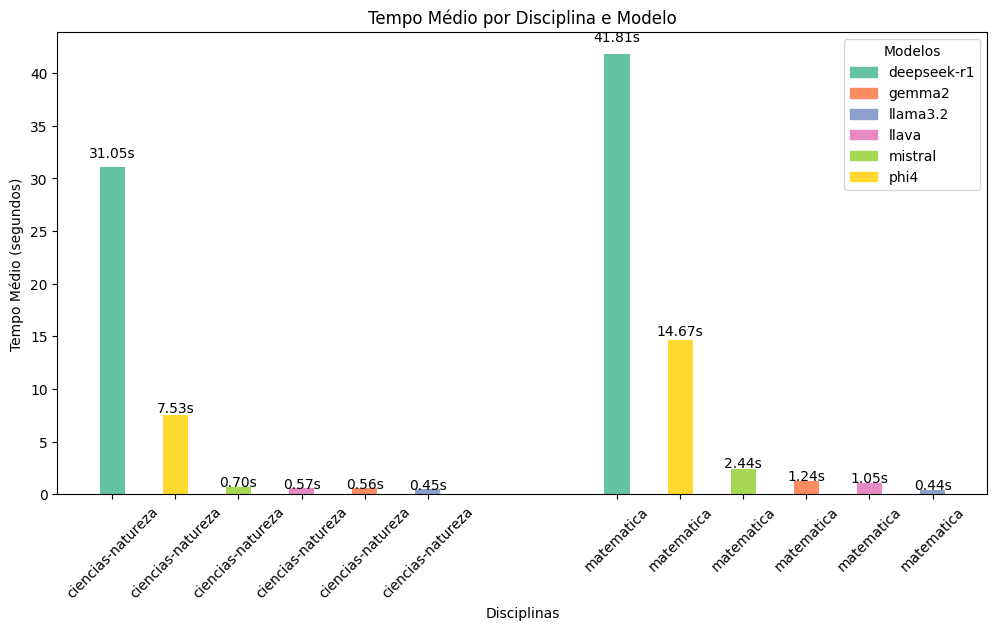

In [93]:
plot_time_performance(df, False)

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_discipline_accuracy_vs_time(df: pd.DataFrame):
    """Gera um gráfico de dispersão mostrando a correlação entre acurácia e tempo médio por disciplina e modelo."""
    df_filtered = df.dropna(subset=["discipline"]).copy()
    df_filtered["time"] = pd.to_numeric(df_filtered["time"], errors="coerce")
    
    grouped = df_filtered.groupby(["model", "discipline"]).agg(
        Avg_Time=("time", "mean"),
        Accuracy=("correct", "mean")
    ).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.get_cmap("tab10", len(grouped["discipline"].unique()))
    color_map = {discipline: colors(i) for i, discipline in enumerate(sorted(grouped["discipline"].unique()))}
    
    for _, row in grouped.iterrows():
        ax.scatter(row["Avg_Time"], row["Accuracy"], color=color_map[row["discipline"]])
        ax.text(row["Avg_Time"], row["Accuracy"], f"{row['model']}-{row['discipline']}", fontsize=9, ha='right', va='bottom')
    
    ax.set_xlabel("Tempo Médio (segundos)")
    ax.set_ylabel("Acurácia")
    ax.set_title("Correlação entre Acurácia e Tempo Médio por Modelo e Disciplina")
    plt.show()

C:\Users\ruben\AppData\Local\Temp\ipykernel_52012\1296490295.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(grouped["discipline"].unique()))


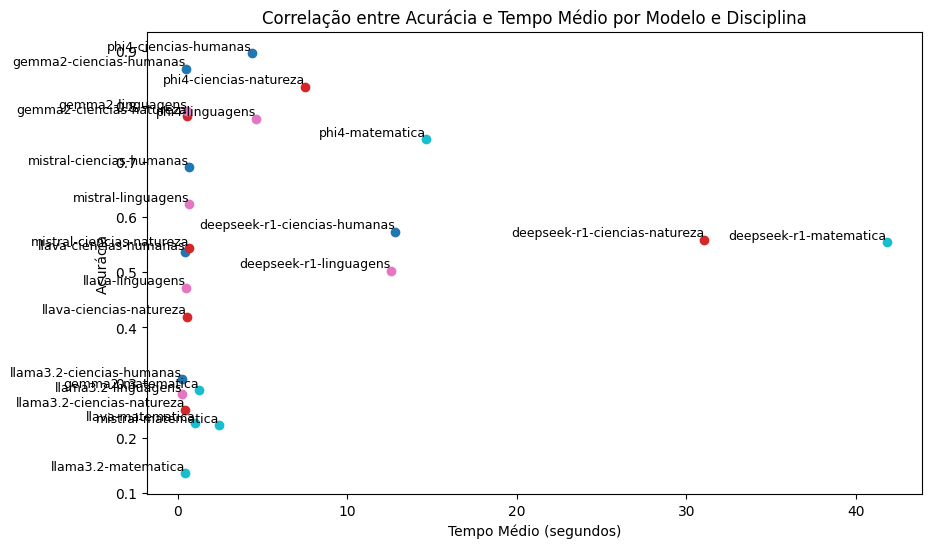

In [97]:
plot_accuracy_vs_time(df)